# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import scipy.stats as stats
import emcee
import corner
from multiprocessing import Pool, cpu_count
import astropy.constants as cst
import copy

from minot.ClusterTools import map_tools
import pitszi
from pitszi import utils
from pitszi import utils_pk

import time

In [2]:
#========== Pixel window function
def pix_mn(k2d_x, k2d_y, reso):
    term1 = np.sinc(k2d_x*reso)
    term2 = np.sinc(k2d_y*reso)
    pix_mn = term1 * term2
    return pix_mn

#========== Pixel window function
def beam_mn(k2d_x, k2d_y, reso, FWHM):
    sigma2fwhm = 2 * np.sqrt(2*np.log(2))
    sigma = FWHM / sigma2fwhm
    k_0 = 1 / (np.sqrt(2) * np.pi * sigma)
    G_k = np.exp(-(k2d_x**2 + k2d_y**2) / k_0**2)
    return G_k

In [3]:
#========== Poker functions to compute the bin to bin mixing matrix
# Equation A.6

def compute_K(W):
    Nx, Ny = W.shape
    K = np.zeros((Nx, Ny, Nx, Ny), dtype=complex)  # m,n,m1,n1
    
    for n1 in range(Ny):
        for m1 in range(Nx):
            for n in range(Ny):
                for m in range(Nx):
                    if m1 <= m and n1 <= n:
                        K[m, n, m1, n1] = W[m - m1, n - n1,]
                    elif m1 <= m and n1 > n:
                        K[m, n, m1, n1] = W[m - m1, Ny + n - n1]
                    elif m1 > m and n1 <= n:
                        K[m, n,  m1, n1] = W[Nx + m - m1, n - n1]
                    elif m1 > m and n1 > n:
                        K[m, n, m1, n1] = W[Nx + m - m1, Ny + n - n1]
    return K

# Equation A.5
def prod_K(K, T):
    Nx, Ny = T.shape
    O = np.zeros((Nx, Ny), dtype=complex)  # m,n
    
    for n in range(Ny):
        for m in range(Nx):
            O[m, n] = np.sum(K[m, n, :, :] * T) / Nx/Ny
    return O

# Equation 11, 12
def compute_RQ(k2d, kedge, beta=0):
    Nx, Ny = k2d.shape
    Nb = len(kedge)-1
    R = np.zeros((Nx, Ny, Nb))
    Q = np.zeros((Nx, Ny, Nb))
    
    for b in range(Nb):
        wbin = (k2d >= kedge[b]) * (k2d < kedge[b+1])
        sigma = np.sum(wbin) # Number of kmn falling in bin
        for n in range(Ny):
            for m in range(Nx):
                cond = (kedge[b] <= k2d[m,n]) and (kedge[b+1] > k2d[m,n])
                if cond:
                    if beta == 0:
                        R[m,n, b] = 1.0 / sigma 
                        Q[m,n, b] = 1.0
                    else:
                        R[m,n, b] = k2d[m,n]**beta / sigma
                        Q[m,n, b] = 1/k2d[m,n]**beta
                else:
                    R[m,n, b] = 0.0
                    Q[m,n, b] = 0.0
    return R, Q

def compute_Mbb(R, K, Q):
    Nx, Ny = R.shape[0], R.shape[1]
    Nb = R.shape[2]
    Mbb = np.zeros((Nb, Nb))
    for ib in range(Nb):
        for jb in range(Nb):            
                sum_KQ  = np.sum(np.abs(K)**2 * (Q[:,:,jb])[np.newaxis, np.newaxis, :, :], axis=(2,3))
                sum_RKQ = np.sum(R[:,:,ib] * sum_KQ)
                Mbb[ib, jb] = sum_RKQ
    return Mbb/(Nx*Ny)**2

# Parameters

In [4]:
output_dir = '/Users/adam/Desktop/pitszi_Mbb/'

In [5]:
#----- Physical model parameters
redshift = 0.4
M500 = 1e15*u.Msun
RA, Dec = 30*u.deg, 55*u.deg

fluct_norm = 0.5
fluct_slope = -11./3
fluct_linj = 800*u.kpc
fluct_ldis = 1*u.kpc

In [6]:
#----- Instrumental parameters
# Beam smoothing
beam_FWHM = 18.0*u.arcsec

# Transfer function
appTF = 1
karcsec = np.linspace(0, 1, 1000)*u.arcsec**-1
kfov = 1/(7*60)
TF = {'k':karcsec, 'TF':1-np.exp(-karcsec.to_value('arcsec-1')/kfov)*appTF}

# Mask
w8_smoothing   = 20*u.arcsec
mask_Ntheta500 = 1.0/2#*100

# Noise
noise_k = lambda k_arcsec: (1e-9 + 3e-9 * (k_arcsec*60)**-1)
noise_r = lambda r_arcsec: (1 + np.exp((r_arcsec-200)/80))*1e-20

In [7]:
#----- Analysis parameters
Nbins_pk = 10
scale_bins = 'log'
kmin_pk = 1/(5*60)*u.arcsec**-1
kmax_pk = 1/(2*5)*u.arcsec**-1 

#method = 'ratio'
method = 'subtract'
dyDeconv = True
do_exact = False

# Generate mock data

In [8]:
#===== Generate a model for the cluster and its fluctuations
mock = pitszi.Model(RA=RA, Dec=Dec, redshift=redshift, M500=M500, silent=True, output_dir=output_dir)
#mock.model_pressure_profile = {'name':'beta', 'n_0':0.1*u.keV/u.cm**3, 'r_c':500*u.kpc, 'beta':0.3}
#mock.model_pressure_profile = {'name':'beta', 'n_0':0.1*u.keV/u.cm**3, 'r_c':300*u.kpc, 'beta':0.5}
mock.set_pressure_profile_universal_param('A10UPP')
#mock.model_pressure_profile = {'name':'GNFW',
#                           'P_0':7e-2*u.keV*u.cm**-3, 'c500':1.5,
#                           'a':1.2223, 'b':5.4905, 'c':1.5}
mock.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                   'Norm': fluct_norm, 
                                   'slope': fluct_slope,
                                   'Linj': fluct_linj,
                                   'Ldis': fluct_ldis}

mock.map_center = SkyCoord(mock.coord.ra, mock.coord.dec, frame="icrs")
mock.map_fov    = [6, 6]*u.arcmin
mock.map_reso  = 5.0*u.arcsec
mock.los_reso  = 27.7*u.kpc
mock.los_size  = 2*u.Mpc
mock.R_truncation = 5*u.Mpc

mock.give_sampling_information()

===== Information relative to the grid sampling =====
   Grid size : 73 , 73 , 73
   Pixel size :      27.7     kpc ;     5.0      arcsec
   Fov size :  [   2021.4   ,   2021.4   ] kpc ; [   6.083    ,   6.083    ] arcmin
   L.o.S. resolution :         27.7     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (30., 55.)>
   k min/max projected :       0.002740  /  0.098630   1/arcsec
   k min/max projected :       0.000495  /  0.017810   1/kpc
   k min/max L.o.S. (eq.) :    0.002739  /  0.098595   1/arcsec
   k min/max L.o.S. :          0.000495  /  0.017803   1/kpc
   k max Nyquist :             0.098595   1/arcsec
   k max Nyquist :             0.017803   1/kpc


Text(0.5, 1.0, 'Fluctuation pressure power spectrum')

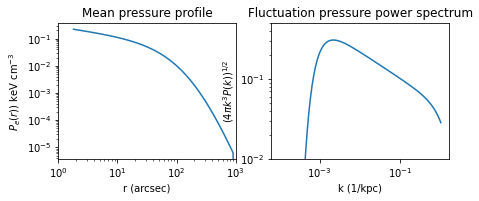

In [9]:
r, p_r = mock.get_pressure_profile(radius=np.logspace(1,4,100)*u.kpc)

k, pk = mock.get_pressure_fluctuation_spectrum(kvec=np.logspace(-1,3,100)*u.Mpc**-1)

plt.figure(0, figsize=(7,2.5))
ax = plt.subplot(1, 2, 1)
plt.loglog(r/mock.D_ang.to_value('kpc')*180/np.pi*3600, p_r)
plt.xlabel('r (arcsec)')
plt.ylabel(r'$P_e(r))$ keV cm$^{-3}$')
plt.title('Mean pressure profile')
#plt.ylim(1e-4,1e0)
plt.xlim(1e0,1e3)

ax = plt.subplot(1, 2, 2)
plt.loglog(k.to_value('kpc-1'), np.sqrt(4*np.pi*k**3*pk).to_value(''))
plt.xlabel('k (1/kpc)')
plt.ylabel(r'$(4 \pi k^3 P(k))^{1/2}$')
plt.ylim(1e-2,5e-1)
plt.title('Fluctuation pressure power spectrum')

In [10]:
#===== Effective maximal scale that can be measured
kmin_eff = 1 / np.amin([(mask_Ntheta500*mock.R500).to_value('kpc'), 
                        mock.get_map_fov(physical=True)[0].to_value('kpc'),
                        mock.get_map_fov(physical=True)[1].to_value('kpc')])
kmax_Nyquist = mock.get_kmax_isotropic(physical=True).to_value('kpc-1')

In [11]:
#===== Initiate a data object and fake data
#----- init with 
data = pitszi.Data(np.zeros((1,1)), '')
data.output_dir = output_dir

#----- set basic IRFs
data.psf_fwhm              = beam_FWHM
data.transfer_function     = TF
data.noise_model_pk_center = noise_k
data.noise_model_radial    = noise_r

#----- Mock the data
img = data.set_image_to_mock(mock, 
                             model_no_fluctuations=False, use_model_header=True, 
                             noise_origin='model', noise_center=mock.map_center)

#----- Define the mask
ramap, decmap = map_tools.get_radec_map(data.header)
dist_map = map_tools.greatcircle(ramap, decmap, data.header['CRVAL1'], data.header['CRVAL2'])
mask = dist_map * 0 + 1
mask[dist_map > mask_Ntheta500*mock.theta500.to_value('deg')] = 0 
data.mask = mask

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in reciprocal
  app.launch_new_instance()


# Get the spherical model

In [12]:
model_ymap_sph    = mock.get_sz_map(no_fluctuations=True)    
model_ymap_sph_TB = mock.get_sz_map(no_fluctuations=True, irfs_convolution_beam=data.psf_fwhm, irfs_convolution_TF=data.transfer_function) 
model_ymap_sph_T  = mock.get_sz_map(no_fluctuations=True, irfs_convolution_TF=data.transfer_function) 
model_ymap_sph_B  = mock.get_sz_map(no_fluctuations=True, irfs_convolution_beam=data.psf_fwhm) 

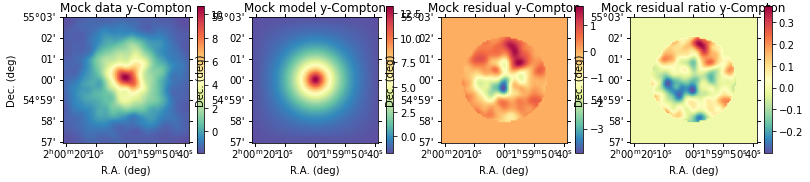

In [13]:
visu_smooth = 10

plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(13, 2.7))

#----- Expected true smooth model
ax = plt.subplot(1, 4, 1, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r')
cb = plt.colorbar()
plt.title('Mock data y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(1, 4, 2, projection=WCS(data.header))
plt.imshow(gaussian_filter(model_ymap_sph_TB, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r')
cb = plt.colorbar()
plt.title('Mock model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(1, 4, 3, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.image - model_ymap_sph_TB, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5*mask, cmap='Spectral_r')#, vmin=-2, vmax=2)
cb = plt.colorbar()
plt.title('Mock residual y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(1, 4, 4, projection=WCS(data.header))
plt.imshow((data.image - model_ymap_sph_TB)/model_ymap_sph_B*mask, cmap='Spectral_r')#, vmin=-0.5, vmax=0.5)
cb = plt.colorbar()
plt.title('Mock residual ratio y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

# Build the model to be used for the fit

In [14]:
inference = pitszi.Inference(data, mock)
inference.output_dir = output_dir
inference.kbin_min   = kmin_pk
inference.kbin_max   = kmax_pk
inference.kbin_Nbin  = Nbins_pk
inference.kbin_scale = scale_bins

# Build the model via Mbb

In [15]:
#========== Define k and binning
kedges = inference.get_kedges(physical=True)
kctr = (0.5 * (kedges[1:] + kedges[:-1])).to_value('kpc-1')
counts = inference.get_kbin_counts()
reso = mock.get_map_reso(physical=True).to_value('kpc')
Nx, Ny = data.image.shape
k2d_x, k2d_y, k2d_norm = inference.get_k_grid(physical=True)

----- Minimal bin counts: 4.0
----- Counts in each k bin: [   4.   12.   16.   32.   68.  140.  276.  532. 1024. 2088.]


In [32]:
inference.model.get_map_reso().to_value('deg')

0.0013888888888889

Text(0.5, 1.0, 'Map used for Pk ($\\delta y/y \\times w$)')

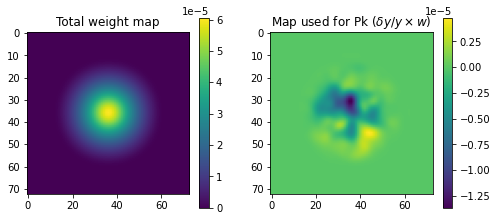

In [16]:
#========== Define the mask and weights
if method == 'subtract':
    mock_tmp = copy.deepcopy(mock)
    try:
        mock_tmp.model_pressure_profile['c'] = 0
    except:
        pass
    w8 = mock_tmp.get_sz_map(no_fluctuations=True, irfs_convolution_beam=data.psf_fwhm, irfs_convolution_TF=data.transfer_function) 
    #w8 = model_ymap_sph_B
    #w8 = np.exp(-0.5*(dist_map*60)**2 / 1**2)
if method == 'ratio':
    w8 = 1
w8tot = gaussian_filter(data.mask * w8, sigma=w8_smoothing.to_value('deg')/2.35/data.header['CDELT2'])
fft_w8tot  = np.fft.fftn(w8tot)

plt.figure(figsize=(8,3.5))
ax = plt.subplot(1, 2, 1)
plt.imshow(w8tot)
plt.colorbar()
plt.title('Total weight map')

ax = plt.subplot(1, 2, 2)
plt.imshow((data.image - model_ymap_sph_TB)/model_ymap_sph_B*w8tot)
plt.colorbar()
plt.title(r'Map used for Pk ($\delta y/y \times w$)')

In [17]:
#========== Mbb computation
# Compute K matrix
start = time.time()
K = compute_K(fft_w8tot)
end = time.time()
print('Computing time K (s):', end - start)

# Compute R,Q matrix
start = time.time()
R,Q = compute_RQ(k2d_norm.to_value('kpc-1'), kedges.to_value('kpc-1'), beta=0)
end = time.time()
print('Computing time R,Q (s):', end - start)

# Compute Mbb matrix
'''
start = time.time()
Mbb = compute_Mbb(R, K, Q)
end = time.time()
print('Computing time Mbb (s):', end - start)

plt.imshow(np.log10(Mbb), vmin=np.amax(np.log10(Mbb))-5, vmax=np.amax(np.log10(Mbb)))
plt.colorbar()
plt.title('Bin-to-bin mixing matrix')
'''

Computing time K (s): 10.328133344650269
Computing time R,Q (s): 0.047796010971069336


"\nstart = time.time()\nMbb = compute_Mbb(R, K, Q)\nend = time.time()\nprint('Computing time Mbb (s):', end - start)\n\nplt.imshow(np.log10(Mbb), vmin=np.amax(np.log10(Mbb))-5, vmax=np.amax(np.log10(Mbb)))\nplt.colorbar()\nplt.title('Bin-to-bin mixing matrix')\n"

In [18]:
#========== Compute test Pk2d
#----- Get the window function
ymap_wf = inference.get_p3d_to_p2d_from_window_function()
conv = np.sum(ymap_wf*w8tot**2) / np.sum(w8tot**2)

#----- Get the test model 3D
idx_sort = np.argsort(k2d_norm.to_value('kpc-1').flatten())
revidx   = np.argsort(idx_sort)
k3d_test = np.sort(k2d_norm.to_value('kpc-1').flatten())
_, pk3d_test = mock.get_pressure_fluctuation_spectrum(k3d_test[1:]*u.kpc**-1)
pk3d_test = pk3d_test.to_value('kpc3')
pk3d_test = np.append(np.array([0]), pk3d_test)
pk3d_test = pk3d_test[revidx]
pk3d_test = pk3d_test.reshape(Nx,Ny)

#----- Convert to 2D
pk2d_test = (pk3d_test*u.kpc**3 * conv).to_value('kpc2') # 2d grid
k2d_test = k2d_norm.to_value('kpc-1')           # 2d grid
pk2d_test_flat = pk2d_test.flatten()
k2d_test_flat = k2d_test.flatten()

#----- Pix, Beam and TF convolution
if dyDeconv:
    print('No convolution of the model')
else:
    pk2d_test_flat = utils_pk.apply_pk_beam(k2d_test_flat, 
                                            pk2d_test_flat, 
                                            beam_FWHM.to_value('rad')*mock.D_ang.to_value('kpc'))
    pk2d_test_flat = utils_pk.apply_pk_transfer_function(k2d_test_flat, 
                                                         pk2d_test_flat, 
                                                         TF['k'].to_value('rad-1')/mock.D_ang.to_value('kpc'),
                                                         TF['TF'])

#----- Input processed with K matrix and binned
input_Pk_K_grid = np.abs(prod_K(np.abs(K)**2, pk2d_test_flat.reshape(Nx, Ny))) / Nx / Ny
input_Pk_K, _, _ = stats.binned_statistic(k2d_test_flat, input_Pk_K_grid.flatten(), 
                                          statistic="mean", bins=kedges.to_value('kpc-1'))

#----- Bin and Mbb
'''
pk2d_test_bin, _, _ = stats.binned_statistic(k2d_test_flat, 
                                             pk2d_test_flat, statistic='mean', 
                                             bins=kedges.to_value('kpc-1'))
pk2d_test_bin_mbb = np.matmul(Mbb, pk2d_test_bin)
'''

No convolution of the model


"\npk2d_test_bin, _, _ = stats.binned_statistic(k2d_test_flat, \n                                             pk2d_test_flat, statistic='mean', \n                                             bins=kedges.to_value('kpc-1'))\npk2d_test_bin_mbb = np.matmul(Mbb, pk2d_test_bin)\n"

In [19]:
#========== Compute test Pk2d with exact method
if do_exact:
    #----- Compute Pk
    start = time.time()
    _, Pk2d_exact = inference.get_p2d_from_p3d_from_window_function_exact()
    end = time.time()
    print('Computing time Pk2d exact (s):', end - start)
    
    #----- Beam and TF
    Pk2d_exact = utils_pk.apply_pk_beam(k2d_test_flat, Pk2d_exact.flatten(), 
                                        beam_FWHM.to_value('rad')*mock.D_ang.to_value('kpc'))
    Pk2d_exact = utils_pk.apply_pk_transfer_function(k2d_test_flat, 
                                                     Pk2d_exact, 
                                                     TF['k'].to_value('rad-1')/mock.D_ang.to_value('kpc'),
                                                     TF['TF'])
    
    #----- Input processed with K matrix and binned
    input_exact_Pk_K_grid  = np.abs(prod_K(np.abs(K)**2, Pk2d_exact.reshape(Nx, Ny))) / Nx / Ny
    input_exact_Pk_K, _, _ = stats.binned_statistic(k2d_test_flat, input_exact_Pk_K_grid.flatten(), 
                                                    statistic="mean", bins=kedges.to_value('kpc-1'))
    
    #----- Bin and Mbb
    '''
    pk2d_exact_bin, _, _ = stats.binned_statistic(k2d_test_flat, Pk2d_exact, 
                                                  statistic='mean', bins=kedges.to_value('kpc-1'))
    pk2d_exact_bin_mbb = np.matmul(Mbb, pk2d_exact_bin)
    '''

# Extract the data Pk2d

In [20]:
Nmc = 100
pk2d_meas_mc1 = np.zeros((Nmc, Nx*Ny))
pk2d_meas_mc1B = np.zeros((Nmc, len(kedges)-1))
pk2d_meas_mc2d = np.zeros((Nmc, Nx,Ny))
for imc in range(Nmc):
    image = inference.model.get_sz_map(no_fluctuations=False, irfs_convolution_beam=beam_FWHM, irfs_convolution_TF=TF) 
    
    if dyDeconv:
        image = utils_pk.deconv_transfer_function(image, mock.get_map_reso().to_value('arcsec'), 
                                                  beam_FWHM.to_value('arcsec'), TF, 
                                                  dec_TF_LS=True, dec_beam=True)
        delta_y = image - model_ymap_sph
        delta_y -= np.mean(delta_y)
        data_image = delta_y/model_ymap_sph*w8tot # Apps none
    else:
        data_image = (image - model_ymap_sph_TB)/model_ymap_sph_B*w8tot # Apps beam
    
    pk2d_meas_mc1[imc,:] = (np.abs(np.fft.fftn(data_image))**2).flatten() * reso**2 / (Nx*Ny)
    pk2d_meas_mc2d[imc,:,:] = (np.abs(np.fft.fftn(data_image))**2) * reso**2 / (Nx*Ny)
    
    pk2d_meas_imc1B, _, _ = stats.binned_statistic(k2d_norm.to_value('kpc-1').flatten(), 
                                                   pk2d_meas_mc1[imc,:], statistic='mean', 
                                                   bins=kedges.to_value('kpc-1'))
    pk2d_meas_mc1B[imc,:] = pk2d_meas_imc1B

    if imc % 50 == 0: print(imc,'/',Nmc)
        
pk2d_meas1  = np.mean(pk2d_meas_mc1, axis=0)
pk2d_meas1B = np.mean(pk2d_meas_mc1B, axis=0)
pk2d_meas1B_std = np.std(pk2d_meas_mc1B, axis=0)
pk2d_meas2d = np.mean(pk2d_meas_mc2d, axis=0)

0 / 100
50 / 100


In [21]:
cov = np.zeros((len(kedges)-1, len(kedges)-1))
for imc in range(Nmc):
    cov += np.matmul((pk2d_meas_mc1B[imc,:] - pk2d_meas1B)[:,None], (pk2d_meas_mc1B[imc,:] - pk2d_meas1B)[None,:])
cov = cov/Nmc

Text(0.5, 1.0, 'Bin-to-bin correlation matrix for the data MC')

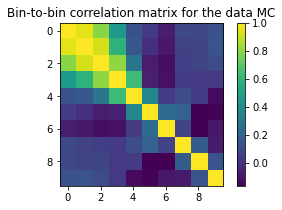

In [22]:
plt.figure(figsize=(5,3))
plt.imshow(utils.correlation_from_covariance(cov))
plt.colorbar()
plt.title('Bin-to-bin correlation matrix for the data MC')

Text(0.5, 1.0, '(MC - model)/MC (%)')

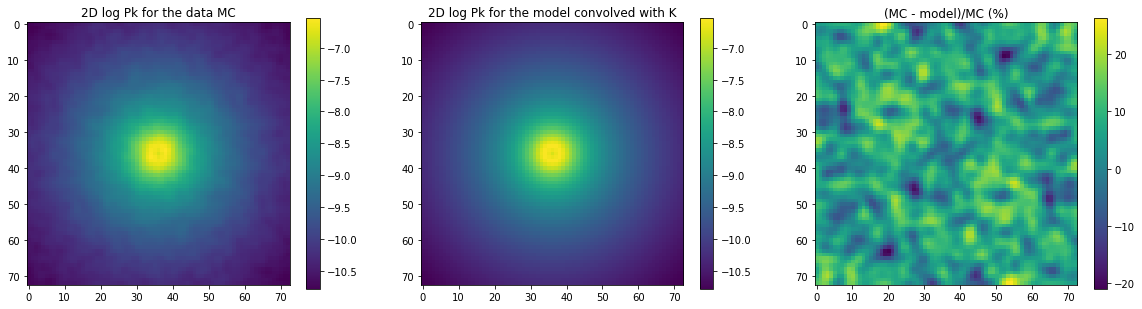

In [23]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(np.log10(np.fft.fftshift(pk2d_meas2d)))
plt.colorbar()
plt.title('2D log Pk for the data MC')

plt.subplot(1,3,2)
plt.imshow(np.log10(np.fft.fftshift(input_Pk_K_grid)), 
           vmin=np.amin(np.log10(np.fft.fftshift(pk2d_meas2d))), vmax=np.amax(np.log10(np.fft.fftshift(pk2d_meas2d))))
plt.colorbar()
plt.title('2D log Pk for the model convolved with K')

plt.subplot(1,3,3)
plt.imshow(gaussian_filter(100*np.fft.fftshift((pk2d_meas2d-input_Pk_K_grid)/pk2d_meas2d), 1))
plt.colorbar()
plt.title('(MC - model)/MC (%)')

Text(0.5, 1.0, 'Beam=18.0, TF=1, method=subtract, smooth w8=20.0')

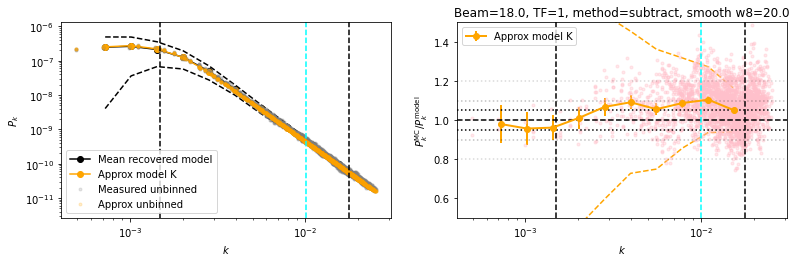

In [24]:
plt.figure(0, figsize=(13,3.6))
plt.subplot(1,2,1)
plt.loglog(kctr, pk2d_meas1B, color='k', marker='o', label='Mean recovered model')
plt.loglog(kctr, pk2d_meas1B + pk2d_meas1B_std, color='k', ls='--')
plt.loglog(kctr, pk2d_meas1B - pk2d_meas1B_std, color='k', ls='--')
plt.loglog(kctr, input_Pk_K, color='orange', marker='o', label='Approx model K')
if do_exact: plt.loglog(kctr, input_exact_Pk_K, color='red', marker='o', label='Exact model K')
plt.loglog(k2d_norm.flatten(), pk2d_meas1, color='grey', marker='.', ls='', alpha=0.2, label='Measured unbinned')
plt.loglog(k2d_norm.flatten(), input_Pk_K_grid.flatten(), color='orange', marker='.', ls='', alpha=0.2, label='Approx unbinned')
if do_exact: plt.loglog(k2d_norm.flatten(), input_exact_Pk_K_grid.flatten(), color='red', marker='o', ls='', alpha=0.2, label='Exact unbinned')
plt.axvline(kmin_eff, ls='--', color='k')
plt.axvline(kmax_Nyquist, ls='--', color='k')
if beam_FWHM>0: plt.axvline(1/(beam_FWHM.to_value('rad')*mock.D_ang.to_value('kpc')), ls='--', color='cyan')
plt.legend()
plt.ylim(np.amax(pk2d_meas1B)*1e-5, np.amax(pk2d_meas1B)*5)
plt.xlabel('$k$')
plt.ylabel(r'$P_k$')

plt.subplot(1,2,2)
plt.errorbar(kctr, (pk2d_meas1B/input_Pk_K), (pk2d_meas1B_std/np.sqrt(Nmc)/input_Pk_K), color='orange', lw=2, marker='o', label='Approx model K')
if do_exact: plt.errorbar(kctr, (pk2d_meas1B/input_exact_Pk_K), (pk2d_meas1B_std/np.sqrt(Nmc)/input_exact_Pk_K), color='red', lw=2, marker='o', label='Exact model K')
plt.plot(kctr, ((pk2d_meas1B+pk2d_meas1B_std)/input_Pk_K), color='orange', ls='--')
plt.plot(kctr, ((pk2d_meas1B-pk2d_meas1B_std)/input_Pk_K), color='orange', ls='--')
if do_exact: plt.plot(kctr, ((pk2d_meas1B+pk2d_meas1B_std)/input_exact_Pk_K), color='red', ls='--')
if do_exact: plt.plot(kctr, ((pk2d_meas1B-pk2d_meas1B_std)/input_exact_Pk_K), color='red', ls='--')
plt.plot(k2d_norm.flatten(), (pk2d_meas1/input_Pk_K_grid.flatten()), color='pink', marker='.', ls='', alpha=0.2)
if do_exact: plt.plot(k2d_norm.flatten(), (pk2d_meas1/input_exact_Pk_K_grid.flatten()), color='red', marker='.', ls='', alpha=0.2)
plt.axhline(1, ls='--', color='k')
plt.axhline(0.95, ls=':', color='k')
plt.axhline(1.05, ls=':', color='k')
plt.axhline(0.9, ls=':', color='k', alpha=0.25)
plt.axhline(1.1, ls=':', color='k', alpha=0.25)
plt.axhline(0.8, ls=':', color='k', alpha=0.15)
plt.axhline(1.2, ls=':', color='k', alpha=0.15)
plt.axvline(kmin_eff, ls='--', color='k')
if beam_FWHM>0: plt.axvline(1/(beam_FWHM.to_value('rad')*mock.D_ang.to_value('kpc')), ls='--', color='cyan')
plt.axvline(kmax_Nyquist, ls='--', color='k')
#plt.axvline(1/fluct_linj.to_value('kpc'), ls=':', color='grey')
plt.xlabel('$k$')
plt.ylabel(r'$P^{\rm MC}_k / P^{\rm model}_k$')
plt.xscale('log')
plt.ylim(0.5,1.5)
plt.legend()
plt.title('Beam='+str(beam_FWHM.value)+', TF='+str(appTF)+', method='+method+', smooth w8='+str(w8_smoothing.value))

Text(0, 0.5, 'PDF')

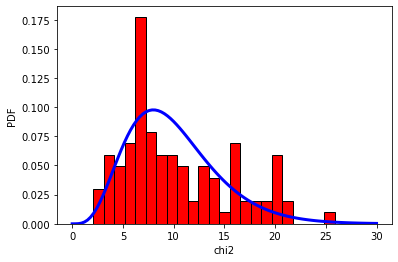

In [25]:
#===== Test if model and data are compatible statistically
invcov = np.linalg.inv(cov)
chi2a = np.zeros(Nmc)
if do_exact: chi2b = np.zeros(Nmc)
for imc in range(Nmc):
    chi2a[imc] = np.matmul((pk2d_meas_mc1B[imc,:]-input_Pk_K), np.matmul(invcov, (pk2d_meas_mc1B[imc,:]-input_Pk_K)))
    if do_exact: chi2b[imc] = np.matmul((pk2d_meas_mc1B[imc,:]-input_exact_Pk_K), np.matmul(invcov, (pk2d_meas_mc1B[imc,:]-input_exact_Pk_K)))

xsample = np.linspace(0, len(kctr)*3, 100)
bins = np.linspace(0,len(kctr)*3, 30)
pdf = stats.chi2.pdf(xsample, df=len(kctr))

plt.hist(chi2a, bins=bins, color='r', density=True, ec='k', alpha=1)
if do_exact: plt.hist(chi2b, bins=bins, color='g', density=True, ec='k', alpha=0.4)
plt.plot(xsample, pdf, lw=3, color='blue')
plt.xlabel('chi2')
plt.ylabel('PDF')

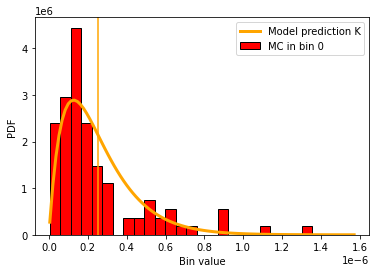

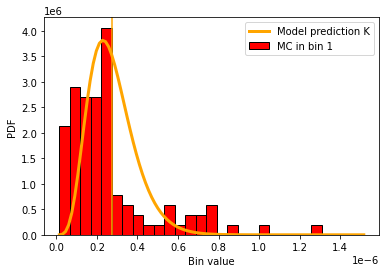

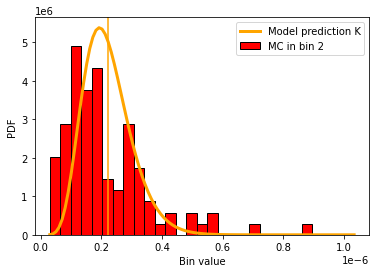

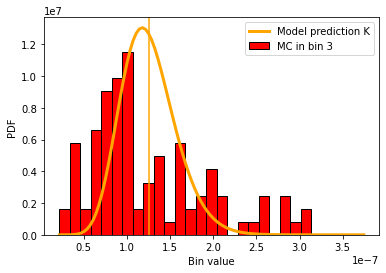

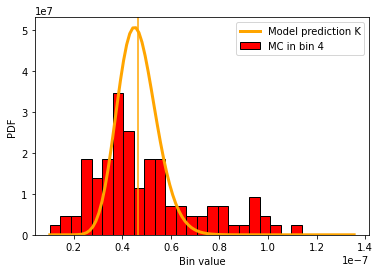

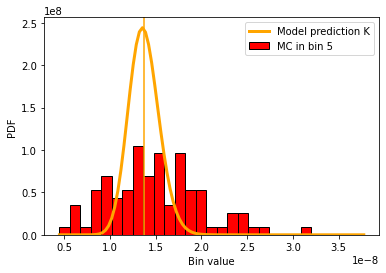

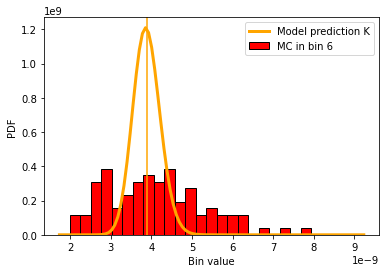

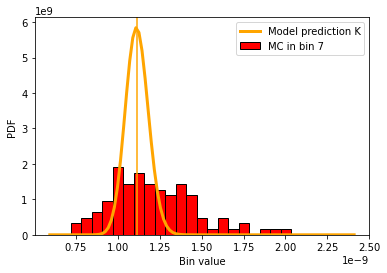

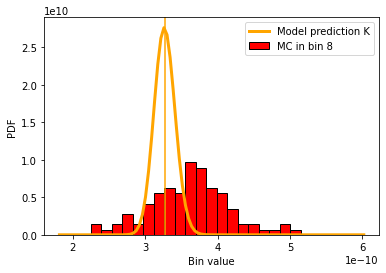

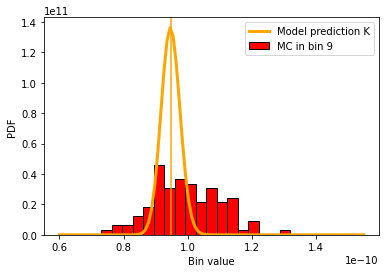

In [26]:
for i in range(len(input_Pk_K)):
    plt.figure(i)
    if do_exact: sigE = input_exact_Pk_K[i]**0.5
    sigK = input_Pk_K[i]**0.5
    
    xsample = np.linspace(np.amin(pk2d_meas_mc1B[:,i])*0.8, np.amax(pk2d_meas_mc1B[:,i])*1.2, 100)
    bins = np.linspace(np.amin(pk2d_meas_mc1B[:,i])*0.8, np.amax(pk2d_meas_mc1B[:,i])*1.2, 30)
    
    if do_exact: pdfE = stats.chi2.pdf(xsample, df=counts[i], scale=sigE**2/counts[i])
    if do_exact: plt.plot(xsample, pdfE, lw=3, color='b', label='Model prediction K exact')
    pdfK = stats.chi2.pdf(xsample, df=counts[i], scale=sigK**2/counts[i])
    plt.plot(xsample, pdfK, lw=3, color='orange', label='Model prediction K')
    
    plt.hist(pk2d_meas_mc1B[:,i], bins=bins, color='r', density=True, ec='k', label='MC in bin '+str(i))
    plt.axvline(sigK**2, color='orange')
    plt.xlabel('Bin value')
    plt.ylabel('PDF')
    plt.legend()

In [34]:
((1*u.kpc/mock.D_ang).to_value('')*u.rad).to_value('arcsec')

0.18057040045004194

In [38]:
None in [None, None]

True